**# Data cleaning**

In [15]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# 1. UNIVERSAL PATHING
# Adjust 'project_dataset' to your local folder name if different
data_folder = "project_dataset"
cash_path = os.path.join(data_folder, "extract - cash request - data analyst.csv")
fees_path = os.path.join(data_folder, "extract - fees - data analyst - .csv")

# 2. LOADING DATA
cash_request = pd.read_csv(cash_path)
fees = pd.read_csv(fees_path)

# 3. DATE CLEANING (Merged logic)
# Combining all date columns identified by the team
cash_date_cols = ["created_at", "updated_at", "moderated_at", "reimbursement_date", 
                  "cash_request_received_date", "money_back_date", "send_at", 
                  "reco_creation", "reco_last_update"]

fees_date_cols = ["created_at", "updated_at", "paid_at", "from_date", "to_date"]

# Apply conversion to cash_request
for col in cash_date_cols:
    if col in cash_request.columns:
        cash_request[col] = pd.to_datetime(cash_request[col], errors='coerce')

# Apply conversion to fees
for col in fees_date_cols:
    if col in fees.columns:
        fees[col] = pd.to_datetime(fees[col], errors='coerce')

# 4. DATA INTEGRITY FIXES
# Ensure IDs are integers for proper merging later
fees["cash_request_id"] = fees["cash_request_id"].astype("Int64")
cash_request["user_id"] = cash_request["user_id"].astype("Int64")

print("✅ System Ready: Data loaded, dates converted, and IDs formatted.")



✅ System Ready: Data loaded, dates converted, and IDs formatted.


These columns were dropped: []


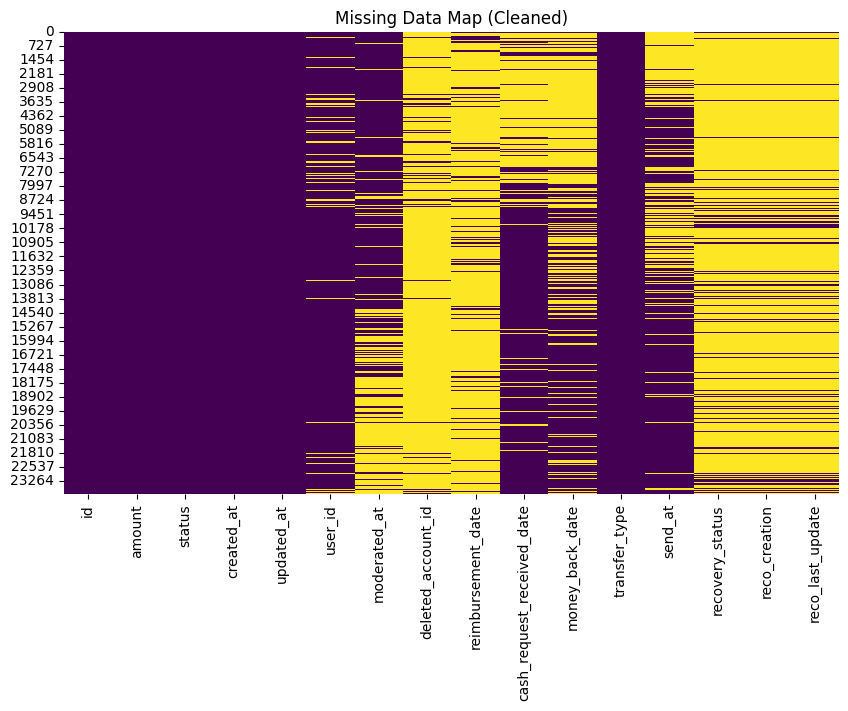

In [ ]:
#Remove Duplicate
cash_request = cash_request.drop_duplicates()
fees = fees.drop_duplicates()

# Remove impossible negative amounts
fees = fees[fees["total_amount"] >= 0]

# Remove fees without a cash_request_id
fees = fees[fees["cash_request_id"].notna()]

#Identify and drop completely empty columns

empty_cols = cash_request.columns[cash_request.isnull().all()]
cash_request = cash_request.drop(columns=empty_cols)

print(f"These columns were dropped: {list(empty_cols)}")

#Take a look at the remaining missing data 
plt.figure(figsize=(10, 6))
sns.heatmap(cash_request.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Map (Cleaned)')
plt.show()



In [35]:
#Cohort Creation

#First Cash request per User
cash_request["cohort_month"] = (cash_request.groupby("user_id")["created_at"].transform(min).dt.to_period("M"))

#Activity month(month of each request)
cash_request["request_month"] = cash_request["created_at"].dt.to_period("M")

cash_request.head()


C:\Users\swapr\AppData\Local\Temp\ipykernel_36564\1189478578.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request["cohort_month"] = (cash_request.groupby("user_id")["created_at"].transform(min).dt.to_period("M"))
C:\Users\swapr\AppData\Local\Temp\ipykernel_36564\1189478578.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request["request_month"] = cash_request["created_at"].dt.to_period("M")


,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,cohort_month,request_month
0,5,100.0,rejected,2019-12-10 19:05:21.596873+00:00,2019-12-11 16:47:42.407830+00:00,804,2019-12-11 16:47:42.405646+00:00,NaN,2020-01-09 19:05:21.596363+00:00,NaT,NaT,regular,NaT,NaN,NaT,NaT,2019-12,2019-12
1,70,100.0,rejected,2019-12-10 19:50:12.347780+00:00,2019-12-11 14:24:22.900054+00:00,231,2019-12-11 14:24:22.897988+00:00,NaN,2020-01-09 19:50:12.347780+00:00,NaT,NaT,regular,NaT,NaN,NaT,NaT,2019-12,2019-12
2,7,100.0,rejected,2019-12-10 19:13:35.825460+00:00,2019-12-11 09:46:59.779773+00:00,191,2019-12-11 09:46:59.777728+00:00,NaN,2020-01-09 19:13:35.825041+00:00,NaT,NaT,regular,NaT,NaN,NaT,NaT,2019-12,2019-12
3,10,99.0,rejected,2019-12-10 19:16:10.880172+00:00,2019-12-18 14:26:18.136163+00:00,761,2019-12-18 14:26:18.128407+00:00,NaN,2020-01-09 19:16:10.879606+00:00,NaT,NaT,regular,NaT,NaN,NaT,NaT,2019-12,2019-12
4,1594,100.0,rejected,2020-05-06 09:59:38.877376+00:00,2020-05-07 09:21:55.340080+00:00,7686,2020-05-07 09:21:55.320193+00:00,NaN,NaT,NaT,NaT,regular,NaT,NaN,NaT,NaT,2020-05,2020-05


In [36]:
#Frequency of service usage
frequency_usage = (
    cash_request.groupby(["cohort_month", "request_month"])
      .agg(request_count=("id", "count"))
      .reset_index()
)


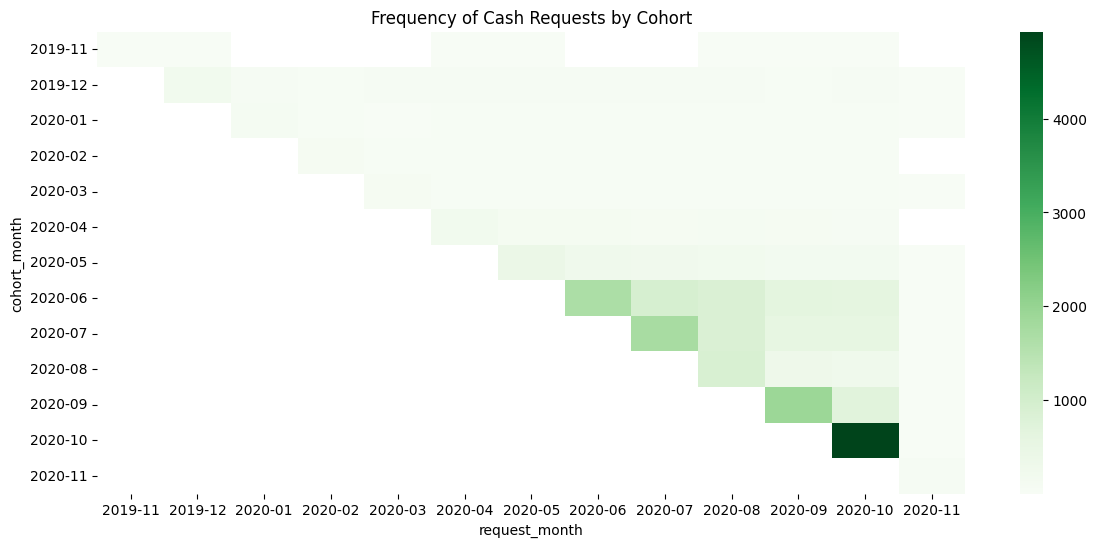

In [37]:
#Rows = Cohort months:Each row is a group of users who made their first cash request in that month
#Columns = Request months:These are the calendar months when users made cash requests.
#Cells = Number of cash requests (request_count)
#Color bar on the right Shows the scale of request_count (from 0 up to ~4000).


freq_pivot = frequency_usage.pivot(index="cohort_month", columns="request_month", values="request_count")
plt.figure(figsize=(14,6))
sns.heatmap(freq_pivot, cmap="Greens", annot=False)
plt.title("Frequency of Cash Requests by Cohort")
plt.show()


In [51]:
#Incident Rate
#Filter incident fees
incident_fees = fees[fees["type"] == "incident"]
incident_fees["fee_month"] = incident_fees["created_at"].dt.to_period("M")

C:\Users\swapr\AppData\Local\Temp\ipykernel_36564\1159155404.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  incident_fees["fee_month"] = incident_fees["created_at"].dt.to_period("M")


In [52]:
#Join with Cash request to get cohort
incident = incident_fees.merge(
    cash_request[["id", "user_id", "cohort_month"]],
    left_on="cash_request_id",
    right_on="id",
    how="left"
)


In [53]:
#Compute incident count
incident_rate = (
    incident.groupby(["cohort_month", "fee_month"])
            .agg(incident_count=("id_x", "count"))
            .reset_index()
)


In [54]:
#Merge with request frequency_usage
incident_rate = incident_rate.merge(
    frequency_usage,
    left_on=["cohort_month", "fee_month"],
    right_on=["cohort_month", "request_month"],
    how="left"
)

incident_rate["incident_rate"] = incident_rate["incident_count"] / incident_rate["request_count"]
incident_rate

,cohort_month,fee_month,incident_count,request_month,request_count,incident_rate
0,2019-12,2020-07,16,2020-07,63,0.253968
1,2019-12,2020-08,6,2020-08,76,0.078947
2,2019-12,2020-09,11,2020-09,50,0.220000
3,2019-12,2020-10,9,2020-10,71,0.126761
4,2020-01,2020-06,1,2020-06,25,0.040000
5,2020-01,2020-07,2,2020-07,28,0.071429
6,2020-01,2020-08,6,2020-08,22,0.272727
7,2020-01,2020-09,6,2020-09,22,0.272727
8,2020-01,2020-10,6,2020-10,24,0.250000
9,2020-02,2020-07,3,2020-07,37,0.081081


In [55]:
#Revenue Generated
#Filter accepted fees
revenue_fees = fees[fees["status"] == "accepted"]
revenue_fees["fee_month"] = revenue_fees["created_at"].dt.to_period("M")

C:\Users\swapr\AppData\Local\Temp\ipykernel_36564\3557488863.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  revenue_fees["fee_month"] = revenue_fees["created_at"].dt.to_period("M")


In [57]:
#Compute revenue per cohort
revenue = (
    revenue_fees.merge(cash_request[["id", "cohort_month"]], 
                       left_on="cash_request_id", 
                       right_on="id")
                .groupby("cohort_month")
                .agg(total_revenue=("total_amount", "sum"))
                .reset_index()
)

In [59]:
#Revenue per cohort per month
revenue_monthly = (
    revenue_fees.merge(cash_request[["id", "cohort_month"]], 
                       left_on="cash_request_id", 
                       right_on="id")
                .groupby(["cohort_month", "fee_month"])
                .agg(total_revenue=("total_amount", "sum"))
                .reset_index()
)

revenue_monthly


,cohort_month,fee_month,total_revenue
0,2019-11,2020-07,5.0
1,2019-11,2020-08,5.0
2,2019-11,2020-09,10.0
3,2019-11,2020-10,10.0
4,2019-12,2020-06,60.0
...,...,...,...
56,2020-09,2020-10,5045.0
57,2020-09,2020-11,100.0
58,2020-10,2020-10,23000.0
59,2020-10,2020-11,180.0
